# IRK schemes with Gauss-Legendre nodes: Solar-System problem

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Definition-of-the-N-body-problem">
             Definition of the N-body problem</a></li>

<li><a href="#Initial-value-problem:-16-body-problem-(Solar-System)">
             Initial value problem: 16-body problem (Solar System)</a></li>

<li><a href="#Integration-with-IRKGL16">
              Integration with IRKGL16</a></li>
              
<li><a href="#Integration-with-IRKNGL16">
              Integration with IRKNGL16</a></li>            

<li><a href="#Error-in-energy">
             Error-in-energy</a></li> 
    
<li><a href="#Benchmarks">
             Benchmarks</a></li> 

</ul>  


## Loading packages

In [1]:
using IRKGaussLegendre

using LinearAlgebra
using Plots
using BenchmarkTools

<a href="#top">Back to the top</a>

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem



**Equations**


The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:

\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}

This system of ODEs can be written in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm).
\end{equation*}


**State variables and parameters**

We implement the state variables as an array with three indices:

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{3\times N \times 2}, 
\end{equation*}

where $u[i,j,k] \in \mathbb{R}$:

- The index $i$ takes the values $y=1,2,3$, referring to the coordinate $x,y,z$ respectively.
- The index $j$ takes the values $j=1,2,\dots,N$, referring to the corresponding planet.
- The index $k$ takes the values $k=1,2$, referring to the position if $k=1$ and the speed if $k=2$.

The vector with the constant parameters of the problem is::

\begin{equation*}
p = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N,
\end{equation*}

where $Gm_i$ corresponds to the mass of the $i$th body multiplied by the universal gravity constant $G$.


<a href="#top">Back to the top</a>

## Initial value problem: 15-body problem (Solar System)

We consider $N=16$ bodies of solar system: the Sun, Mercury, Venus, the Earth, Mars, Jupiter, Saturn, Uranus, Neptune,  Pluto
the Moon, Ceres, Pallas, Vesta, Iris, Bamberga.
The initial values $u_0$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969).

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [2]:
include("../ODEProblems/Initial15Body.jl")
u0, Gm, bodylist = Initial15Body()
N = length(Gm)
size(u0)

(3, 15, 2)

## Number of stages

In [3]:
s=8     # 8,4,2
dt = 5.0   # 5.0, 5.0/2^2, 5.0/2^4

5.0

<a href="#top">Back to the top</a>


## Integration with IRKGL16

Just to check that the output of the function NbodyODE has the expected type:

In [4]:
include("../ODEProblems/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
size(du0)

(3, 15, 2)

Set up of the problem and integrate with symplectic integrator IRKGL16 

#### Constant step-size

In [5]:
t0 = 0.
T = 1000. # Final time

tspan=(t0,T)
prob=ODEProblem{true,SciMLBase.FullSpecialize}(NbodyODE!,u0,tspan,Gm);

In [6]:
# Fully sequential
sol0=solve(prob,IRKGL16(s=s, simd=false),dt=dt,adaptive=false)
@show (sol0.destats.nfpiter/(sol0.destats.naccept+sol0.destats.naccept))
sol0.destats

sol0.destats.nfpiter / (sol0.destats.naccept + sol0.destats.naccept) = 5.2175


SciMLBase.DEStats
Number of function 1 evaluations:                  16696
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           2087
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [7]:
# Fully vectorized
sol1=solve(prob,IRKGL16(s=s, simd=true, fseq=false),dt=dt,adaptive=false)
@show (sol1.destats.nfpiter/(sol1.destats.naccept+sol1.destats.naccept))
sol1.destats

sol1.destats.nfpiter / (sol1.destats.naccept + sol1.destats.naccept) = 5.1525


SciMLBase.DEStats
Number of function 1 evaluations:                  16488
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           2061
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [8]:
norm(sol0.u[end]-sol1.u[end])

8.657793519897786e-15

In [9]:
# Hybrid
sol1b=solve(prob,IRKGL16(),dt=dt,adaptive=false)
@show (sol1b.destats.nfpiter/(sol1b.destats.naccept+sol1b.destats.naccept))
sol1b.destats

sol1b.destats.nfpiter / (sol1b.destats.naccept + sol1b.destats.naccept) = 5.1525


SciMLBase.DEStats
Number of function 1 evaluations:                  16488
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           2061
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [10]:
norm(sol0.u[end]-sol1b.u[end])

8.657793519897786e-15

#### Adaptive step-size

In [11]:
# Fully sequential
sol2=solve(prob,IRKGL16(s=s, simd=false),adaptive=true,reltol=1e-16,abstol=1e-16)
@show (sol2.destats.nfpiter/(sol2.destats.naccept+sol2.destats.naccept))
sol2.destats

sol2.destats.nfpiter / (sol2.destats.naccept + sol2.destats.naccept) = 8.390243902439025


SciMLBase.DEStats
Number of function 1 evaluations:                  16512
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           2064
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          123
Number of rejected steps:                          22

In [12]:
norm(sol0.u[end]-sol2.u[end])

4.401232264700196e-15

In [13]:
# Fully vectorized
sol3=solve(prob,IRKGL16(s=s, simd=true, fseq=false),adaptive=true,reltol=1e-16,abstol=1e-16)
@show (sol3.destats.nfpiter/(sol3.destats.naccept+sol3.destats.naccept))
sol3.destats

sol3.destats.nfpiter / (sol3.destats.naccept + sol3.destats.naccept) = 9.138211382113822


SciMLBase.DEStats
Number of function 1 evaluations:                  17984
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           2248
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          123
Number of rejected steps:                          22

In [14]:
norm(sol0.u[end]-sol3.u[end])

1.3352251170550285e-14

In [15]:
# Hybrid
sol3b=solve(prob,IRKGL16(),adaptive=true,reltol=1e-16,abstol=1e-16)
@show (sol3b.destats.nfpiter/(sol3b.destats.naccept+sol3b.destats.naccept))
sol3b.destats

sol3b.destats.nfpiter / (sol3b.destats.naccept + sol3b.destats.naccept) = 9.138211382113822


SciMLBase.DEStats
Number of function 1 evaluations:                  17984
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           2248
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          123
Number of rejected steps:                          22

In [16]:
norm(sol0.u[end]-sol3b.u[end])

1.3352251170550285e-14

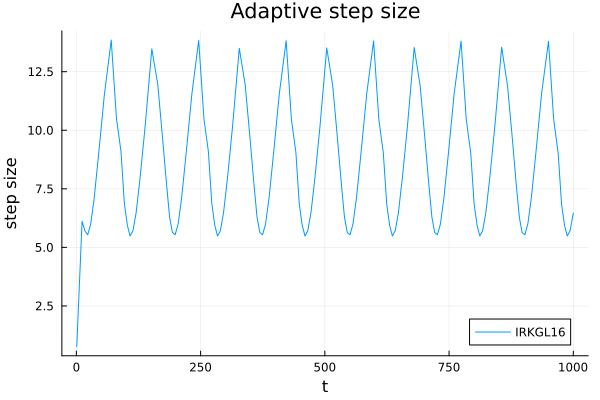

In [17]:
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(sol2.t[2:end],steps2, label="IRKGL16")

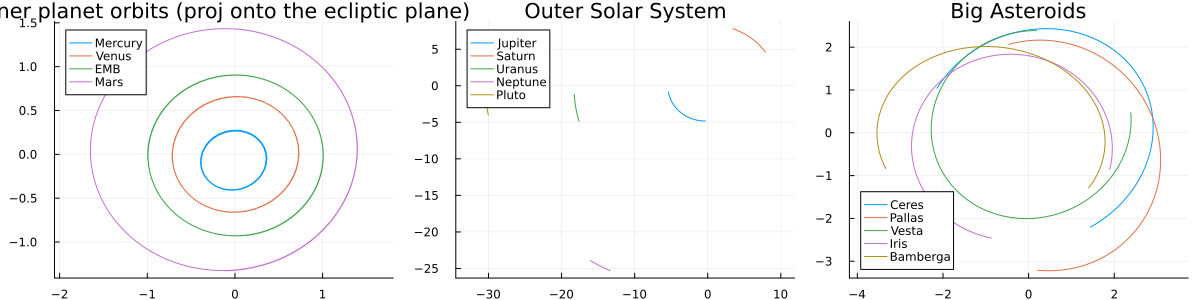

In [18]:
bodylist = ["Sun", "Mercury", "Venus", "EMB", "Mars", "Jupiter", "Saturn", 
            "Uranus", "Neptune", "Pluto",  "Ceres", "Pallas", "Vesta", 
             "Iris", "Bamberga"]
ulist0 = sol0.u
tlist0 = sol0.t


pl1 = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 2:5
 xlist  = map(u->u[1,j,1], ulist0)
 ylist  = map(u->u[2,j,1], ulist0)
 pl1 = plot!(xlist,ylist, label = bodylist[j])   
end   

pl2 = plot(title="Outer Solar System", 
          aspect_ratio=1)

for j = 6:10
 xlist  = map(u->u[1,j,1], ulist0)
 ylist  = map(u->u[2,j,1], ulist0)
 pl2 = plot!(xlist,ylist, label = bodylist[j])   
end  

pl3 = plot(title="Big Asteroids", 
          aspect_ratio=1)

for j = 11:15
 xlist  = map(u->u[1,j,1], ulist0)
 ylist  = map(u->u[2,j,1], ulist0)
 pl3 = plot!(xlist,ylist, label = bodylist[j])   
end  

 
plot(pl1,pl2,pl3, layout=(1,3), size=(1200,300))

<a href="#top">Back to the top</a>


## Integration with IRKNGL16

#### Constant step-size

In [19]:
# Fully sequential
sol13=solve(prob,IRKGL16(s=s, simd=false, second_order_ode=true),dt=dt,adaptive=false)
@show (sol13.destats.nfpiter/(sol13.destats.naccept+sol13.destats.naccept))
sol13.destats

sol13.destats.nfpiter / (sol13.destats.naccept + sol13.destats.naccept) = 2.6325


SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  8424
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           1053
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [20]:
# Fully vectorized
sol14=solve(prob,IRKGL16(s=s, simd=true, fseq=false, second_order_ode=true),dt=dt,adaptive=false)
@show (sol14.destats.nfpiter/(sol14.destats.naccept+sol14.destats.naccept))
sol14.destats

sol14.destats.nfpiter / (sol14.destats.naccept + sol14.destats.naccept) = 2.58


SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  8256
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           1032
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [21]:
norm(sol13.u[end]-sol14.u[end])

7.892228963902002e-15

In [22]:
# Hybr
sol14b=solve(prob,IRKGL16(second_order_ode=true),dt=dt,adaptive=false)
@show (sol14b.destats.nfpiter/(sol14b.destats.naccept+sol14b.destats.naccept))
sol14b.destats

sol14b.destats.nfpiter / (sol14b.destats.naccept + sol14b.destats.naccept) = 2.58


SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  8256
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           1032
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          200
Number of rejected steps:                          0

In [23]:
norm(sol13.u[end]-sol14b.u[end])

7.892228963902002e-15

#### Adaptive step-size

In [24]:
# Fully sequential
sol16=solve(prob, IRKGL16(s=s, simd=false,  second_order_ode=true), dt=dt, adaptive=true,reltol=1e-16,abstol=1e-16)
@show (sol16.destats.nfpiter/(sol16.destats.naccept+sol16.destats.naccept))
sol16.destats

sol16.destats.nfpiter / (sol16.destats.naccept + sol16.destats.naccept) = 4.0534351145038165


SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  8496
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           1062
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          131
Number of rejected steps:                          23

In [25]:
# Fully vectorized
sol17=solve(prob, IRKGL16(s=s, simd=true, fseq=false, second_order_ode=true), dt=dt, adaptive=true,reltol=1e-16,abstol=1e-16)
@show (sol17.destats.nfpiter/(sol17.destats.naccept+sol17.destats.naccept))
sol17.destats

sol17.destats.nfpiter / (sol17.destats.naccept + sol17.destats.naccept) = 3.99618320610687


SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  8376
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           1047
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          131
Number of rejected steps:                          23

In [26]:
norm(sol16.u[end]-sol17.u[end])

3.212514571074394e-14

In [27]:
# Hybr
sol17b=solve(prob, IRKGL16(second_order_ode=true), dt=dt, adaptive=true,reltol=1e-16,abstol=1e-16)
@show (sol17b.destats.nfpiter/(sol17b.destats.naccept+sol17b.destats.naccept))
sol17b.destats

sol17b.destats.nfpiter / (sol17b.destats.naccept + sol17b.destats.naccept) = 3.99618320610687


SciMLBase.DEStats
Number of function 1 evaluations:                  0
Number of function 2 evaluations:                  8376
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:           1047
Number of fixed-point solver convergence failures: 0
Number of rootfind condition calls:                0
Number of accepted steps:                          131
Number of rejected steps:                          23

In [28]:
norm(sol16.u[end]-sol17b.u[end])

3.212514571074394e-14

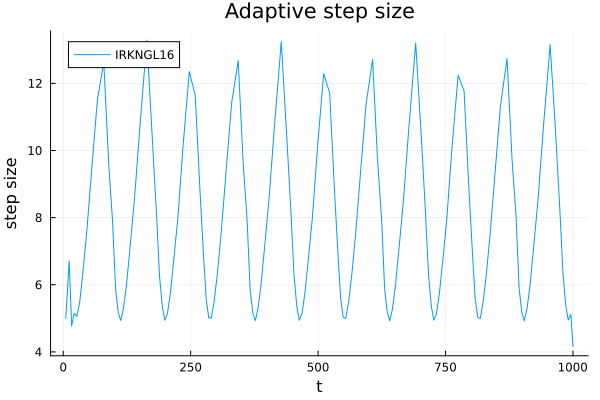

In [29]:
steps16 =sol16.t[2:end]-sol16.t[1:end-1]
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(sol16.t[2:end],steps16, label="IRKNGL16")

<a href="#top">Back to the top</a>


## Error in energy

In [30]:
[sol0.retcode sol1.retcode sol1b.retcode sol2.retcode sol3.retcode sol3b.retcode]

1×6 Matrix{SciMLBase.ReturnCode.T}:
 ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1

In [31]:
[sol13.retcode sol14.retcode sol14b.retcode sol16.retcode sol17.retcode sol17b.retcode]

1×6 Matrix{SciMLBase.ReturnCode.T}:
 ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1  ReturnCode.Success = 1

In [32]:
#(minimum(abs.(EnergyErrors)), maximum(abs.(EnergyErrors)))

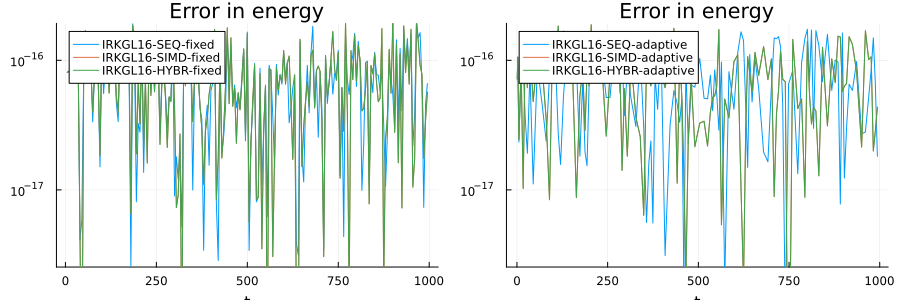

In [33]:
E0=NbodyEnergy(BigFloat.(u0),BigFloat.(Gm))
#yrange=(1e-18, 1e-15)

ulist = sol0.u[2:end-1]
tlist = sol0.t[2:end-1]
EnergyErrors=[NbodyEnergy(BigFloat.(ulist[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist)]
yrange=(minimum(abs.(EnergyErrors)), maximum(abs.(EnergyErrors)))

ulist1 = sol1.u[2:end-1]
tlist1 = sol1.t[2:end-1]
EnergyErrors1=[NbodyEnergy(BigFloat.(ulist1[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist1)]

ulist1b = sol1b.u[2:end-1]
tlist1b = sol1b.t[2:end-1]
EnergyErrors1b=[NbodyEnergy(BigFloat.(ulist1b[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist1b)]

ulist2 = sol2.u[2:end-1]
tlist2 = sol2.t[2:end-1]
EnergyErrors2=[NbodyEnergy(BigFloat.(ulist2[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist2)]

ulist3 = sol3.u[2:end-1]
tlist3 = sol3.t[2:end-1]
EnergyErrors3=[NbodyEnergy(BigFloat.(ulist3[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist3)]

ulist3b = sol3b.u[2:end-1]
tlist3b = sol3b.t[2:end-1]
EnergyErrors3b=[NbodyEnergy(BigFloat.(ulist3b[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist3b)]

pl1=plot( tlist[1:end],abs.(EnergyErrors), xlabel="t", yscale=:log10, ylims=yrange,
          title="Error in energy", label="IRKGL16-SEQ-fixed")
plot!(pl1, tlist1[1:end],abs.(EnergyErrors1), label="IRKGL16-SIMD-fixed")
plot!(pl1, tlist1b[1:end],abs.(EnergyErrors1b), label="IRKGL16-HYBR-fixed")

pl2=plot(tlist2[1:end],abs.(EnergyErrors2),  xlabel="t",  yscale=:log10, ylims=yrange,
           title="Error in energy", label="IRKGL16-SEQ-adaptive")
plot!(pl2, tlist3[1:end],abs.(EnergyErrors3), label="IRKGL16-SIMD-adaptive")
plot!(pl2, tlist3b[1:end],abs.(EnergyErrors3b), label="IRKGL16-HYBR-adaptive")

plot(pl1, pl2, layout=(1,2), size=(900,300))

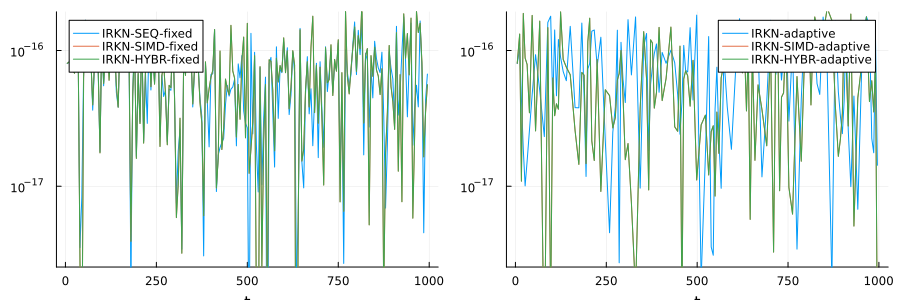

In [34]:
E0=NbodyEnergy(BigFloat.(u0),BigFloat.(Gm))
#yrange=(1e-18, 1e-15)


ulist13 = sol13.u[2:end-1]
tlist13 = sol13.t[2:end-1]
EnergyErrors13=[NbodyEnergy(BigFloat.(ulist13[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist13)]

ulist14 = sol14.u[2:end-1]
tlist14 = sol14.t[2:end-1]
EnergyErrors14=[NbodyEnergy(BigFloat.(ulist14[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist14)]

ulist14b = sol14b.u[2:end-1]
tlist14b = sol14b.t[2:end-1]
EnergyErrors14b=[NbodyEnergy(BigFloat.(ulist14b[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist14b)]

ulist16 = sol16.u[2:end-1]
tlist16 = sol16.t[2:end-1]
EnergyErrors16=[NbodyEnergy(BigFloat.(ulist16[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist16)]

ulist17 = sol17.u[2:end-1]
tlist17 = sol17.t[2:end-1]
EnergyErrors17=[NbodyEnergy(BigFloat.(ulist17[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist17)]

ulist17b = sol17b.u[2:end-1]
tlist17b = sol17b.t[2:end-1]
EnergyErrors17b=[NbodyEnergy(BigFloat.(ulist17b[j]),BigFloat.(Gm))/E0-1 for j in 1:length(tlist17b)]

pl1=plot(xlabel="t", yscale=:log10, ylims=yrange)
plot!(pl1, tlist13[1:end],abs.(EnergyErrors13), label="IRKN-SEQ-fixed")
plot!(pl1, tlist14[1:end],abs.(EnergyErrors14), label="IRKN-SIMD-fixed")
plot!(pl1, tlist14b[1:end],abs.(EnergyErrors14b), label="IRKN-HYBR-fixed")

pl2=plot(xlabel="t", yscale=:log10, ylims=yrange)
plot!(pl2, tlist16[1:end],abs.(EnergyErrors16), label="IRKN-adaptive")
plot!(pl2, tlist17[1:end],abs.(EnergyErrors17), label="IRKN-SIMD-adaptive")
plot!(pl2, tlist17b[1:end],abs.(EnergyErrors17b), label="IRKN-HYBR-adaptive")

plot(pl1, pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>


## Benchmarks

### IRKGL16

#### Constant step-size

In [35]:
# Fully sequential
@btime solve(prob,IRKGL16(s=s,simd=false),dt=dt,adaptive=false, save_everystep=false)
@show sol0.stats.naccept

  35.097 ms (307 allocations: 52.27 KiB)
sol0.stats.naccept = 200


200

In [36]:
# Fully vectorized
@btime solve(prob,IRKGL16(s=s,simd=true, fseq=false),dt=dt,adaptive=false, save_everystep=false)
@show sol1.stats.naccept

  7.117 ms (288 allocations: 50.33 KiB)
sol1.stats.naccept = 200


200

In [37]:
# Hybr
#@btime solve(prob,IRKGL16(s=s,simd=true, fseq=true),dt=dt,adaptive=false, save_everystep=false)
@btime solve(prob,IRKGL16() ,dt=dt,adaptive=false, save_everystep=false)
@show sol1b.stats.naccept

  20.079 ms (286 allocations: 50.27 KiB)
sol1b.stats.naccept = 200


200

#### Adaptive step-size

In [38]:
# Fully sequential
@btime solve(prob,IRKGL16(s=s, simd=false),adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol2.stats.naccept

  35.332 ms (593 allocations: 214.44 KiB)
sol2.stats.naccept = 123


123

In [39]:
# Fully vectorized
@btime solve(prob,IRKGL16(s=s,simd=true, fseq=false),adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol3.stats.naccept

  8.064 ms (574 allocations: 212.50 KiB)
sol3.stats.naccept = 123


123

In [40]:
# Hybr
#@btime solve(prob,IRKGL16(s=s,simd=true, fseq=true),adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@btime solve(prob,IRKGL16(),adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol3b.stats.naccept

  22.147 ms (572 allocations: 212.44 KiB)
sol3b.stats.naccept = 123


123

In [41]:
2^(-23)

1.1920928955078125e-7

### IRKNGL16

#### Constant step-size

In [42]:
# Fully sequential
@btime solve(prob,IRKGL16(s=s,simd=false,second_order_ode=true),dt=dt,adaptive=false, save_everystep=false)
@show sol13.stats.naccept

  12.276 ms (307 allocations: 52.27 KiB)
sol13.stats.naccept = 200


200

In [43]:
# Fully vectorized
@btime solve(prob,IRKGL16(s=s,simd=true,fseq=false, second_order_ode=true),dt=dt,adaptive=false, save_everystep=false)
@show sol14.stats.naccept

  3.073 ms (288 allocations: 50.33 KiB)
sol14.stats.naccept = 200


200

In [44]:
# Hybr
#@btime solve(prob,IRKGL16(s=s,simd=true,fseq=true, second_order_ode=true),dt=dt,adaptive=false, save_everystep=false)
@btime solve(prob,IRKGL16(second_order_ode=true),dt=dt,adaptive=false, save_everystep=false)
@show sol14.stats.naccept

  9.322 ms (286 allocations: 50.27 KiB)
sol14.stats.naccept = 200


200

#### Adaptive step-size

In [45]:
@btime solve(prob, IRKGL16(s=s,simd=false, second_order_ode=true), adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol16.stats.naccept

  14.277 ms (616 allocations: 227.38 KiB)
sol16.stats.naccept = 131


131

In [46]:
# Fully vecrtorized
@btime solve(prob, IRKGL16(s=s,simd=true,fseq=false, second_order_ode=true), adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol17.stats.naccept

  3.423 ms (597 allocations: 225.44 KiB)
sol17.stats.naccept = 131


131

In [47]:
# Hybr
@btime solve(prob, IRKGL16(second_order_ode=true), adaptive=true,reltol=1e-16,abstol=1e-16, save_everystep=false)
@show sol17b.stats.naccept

  9.787 ms (595 allocations: 225.38 KiB)
sol17b.stats.naccept = 131


131